# Assignment 02 - Loading and Visualizing Data

# NYC Waste Management Data


In [30]:
%matplotlib ipympl

# the bare minimum
import matplotlib.pyplot as plt
import seaborn
import geopandas as gpd
import pandas as pd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

### Load NYC Open Data Sets 

In [31]:
litter_baskets = ogr.read_dataframe("../Data/dsny/DSNY_Litter_Basket_Inventory_20240716.geojson")

In [32]:
monthly_tonnage = pd.read_csv("../Data/dsny/DSNY_Monthly_Tonnage_Data_20240716.csv")

In [33]:
waste_zones = ogr.read_dataframe("../Data/dsny/DSNY_Planned_Commercial_Waste_Zones_20240716.geojson")

## Exploring Monthly Tonnage Data

In [34]:
monthly_tonnage

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID
0,1990 / 08,Manhattan,03,3258.3,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1990 / 10,Manhattan,03,3829.9,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1990 / 10,Staten Island,02,4379.5,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,1990 / 10,Manhattan,07,3463.6,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1990 / 11,Manhattan,02,3014.2,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
23763,2024 / 07,Brooklyn,16,555.7,13.4,30.2,3.0,NaN,NaN,NaN,3.0
23764,2024 / 06,Manhattan,05,1290.6,238.1,145.5,NaN,NaN,NaN,NaN,1.0
23765,2024 / 03,Queens,13,4704.5,422.1,746.5,53.1,50.5,NaN,NaN,4.0
23766,2024 / 07,Brooklyn,08,718.4,64.8,56.4,11.7,NaN,NaN,NaN,3.0


In [35]:
monthly_tonnage.columns

Index(['MONTH', 'BOROUGH', 'COMMUNITYDISTRICT', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'RESORGANICSTONS',
       'SCHOOLORGANICTONS', 'LEAVESORGANICTONS', 'XMASTREETONS', 'BOROUGH_ID'],
      dtype='object')

<Axes: xlabel='MONTH'>

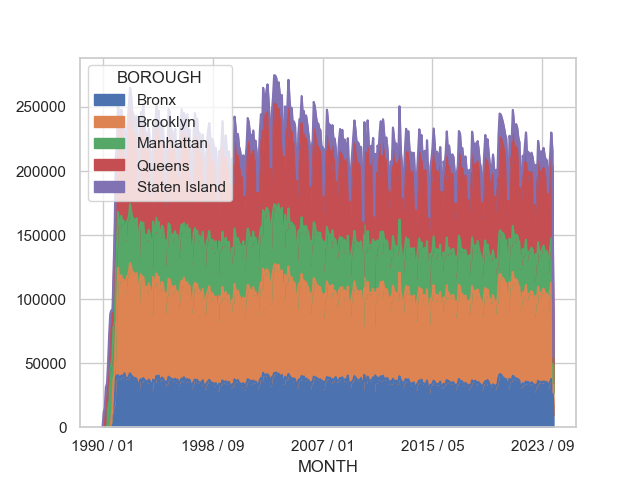

In [36]:
monthly_tonnage.groupby(["MONTH", "BOROUGH"])["REFUSETONSCOLLECTED"].sum().unstack().plot(kind="area", stacked=True)

<Axes: xlabel='MONTH'>

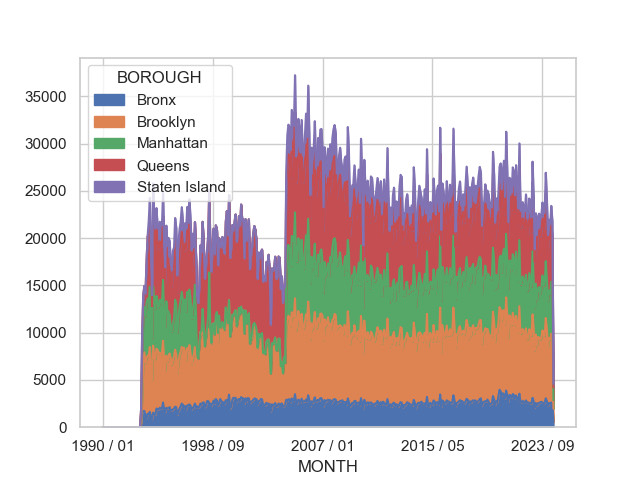

In [37]:
monthly_tonnage.groupby(["MONTH", "BOROUGH"])["PAPERTONSCOLLECTED"].sum().unstack().plot(kind="area", stacked=True)

<Axes: xlabel='MONTH'>

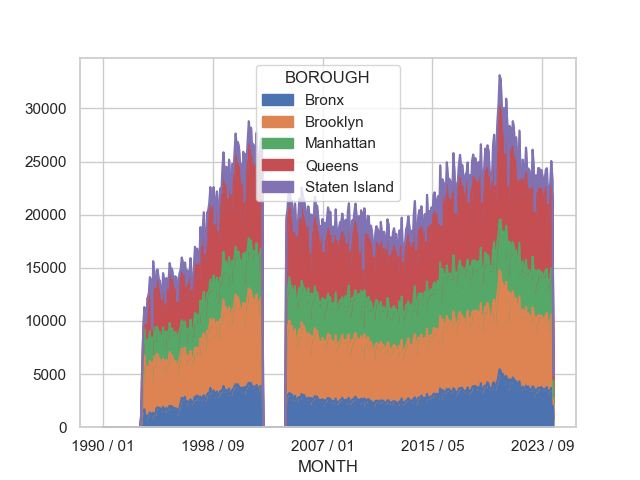

In [38]:
monthly_tonnage.groupby(["MONTH", "BOROUGH"])["MGPTONSCOLLECTED"].sum().unstack().plot(kind="area", stacked=True)

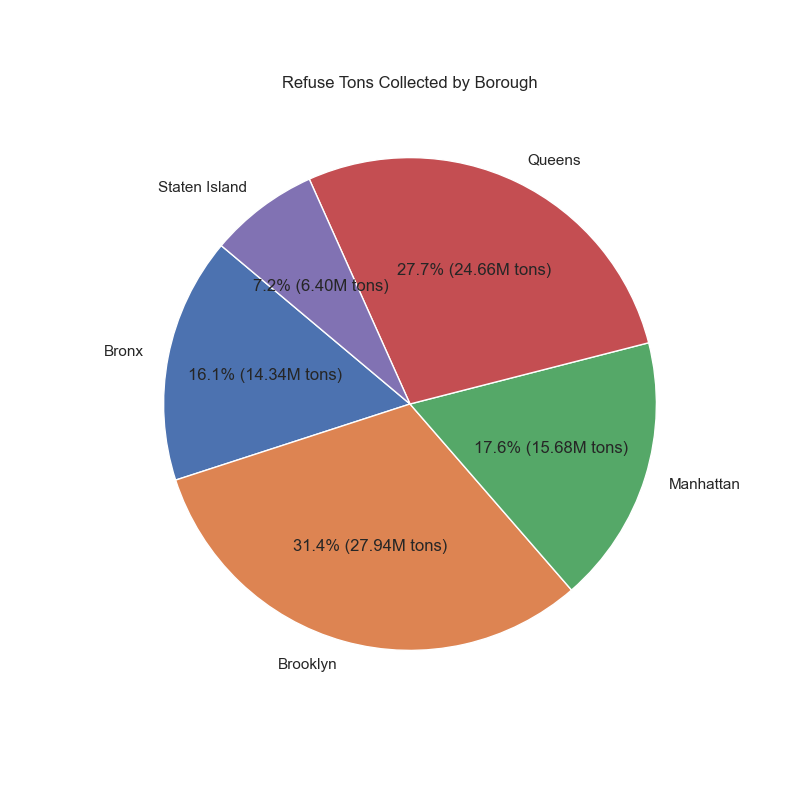

In [39]:
data = monthly_tonnage.groupby(["BOROUGH"])["REFUSETONSCOLLECTED"].sum().reset_index()
total_sum = data["REFUSETONSCOLLECTED"].sum()
plt.figure(figsize=(8, 8))
seaborn.set(style="whitegrid")
def format_tons(tons):
    if tons >= 1e6:
        return '{:.2f}M tons'.format(tons / 1e6)
    elif tons >= 1e3:
        return '{:.2f}K tons'.format(tons / 1e3)
    else:
        return '{:.2f} tons'.format(tons)

plt.pie(data["REFUSETONSCOLLECTED"], labels=data["BOROUGH"], autopct=lambda p: '{:.1f}% ({})'.format(p, format_tons(p * total_sum / 100)), startangle=140)
plt.title('Refuse Tons Collected by Borough')
plt.show()

## Exploring Litter Basket Data

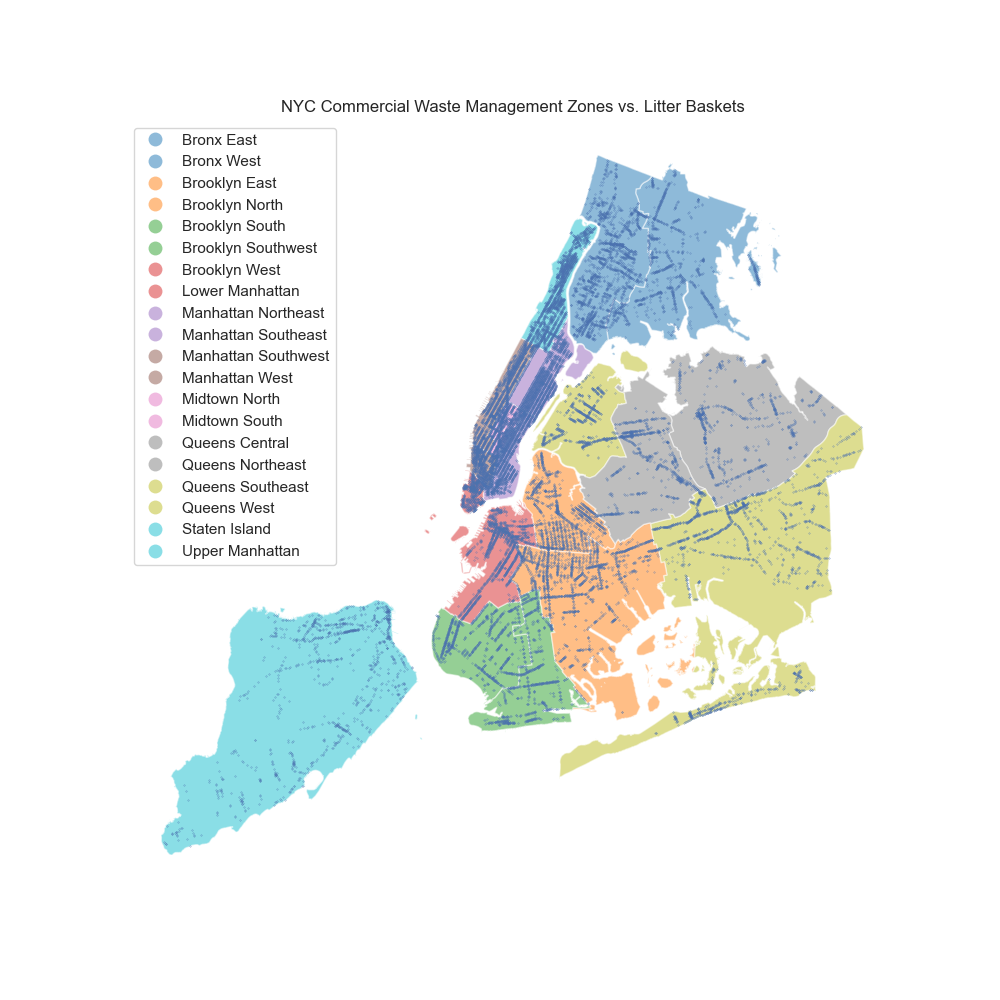

In [40]:
ax = waste_zones.plot(figsize=(10, 10), alpha=0.5, column='zone_name', legend=True)
litter_baskets.plot(ax=ax, markersize=0.05)
ax.set_axis_off()
plt.title("NYC Commercial Waste Management Zones vs. Litter Baskets")
plt.show()

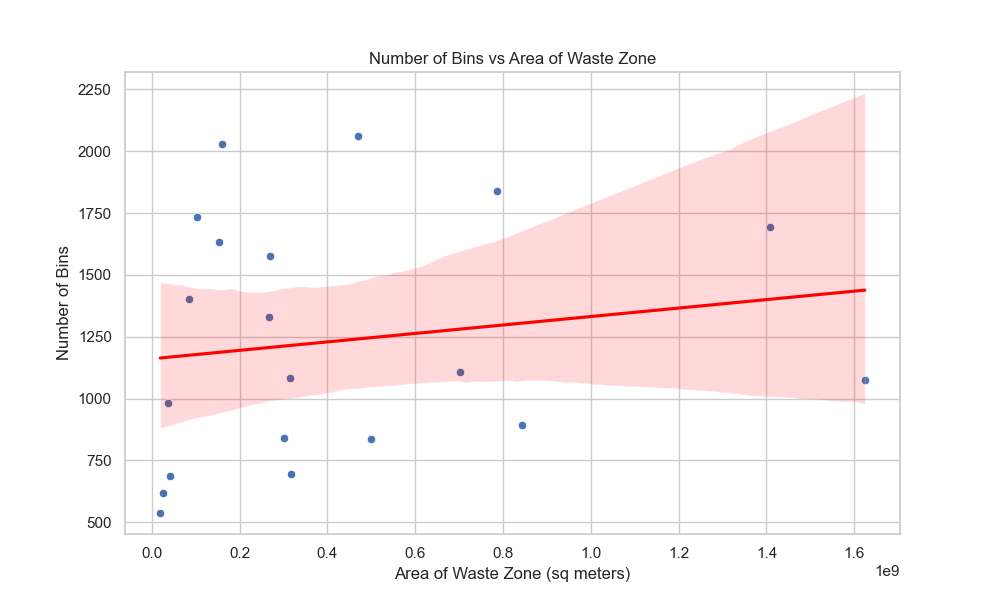

In [51]:
# Perform a spatial join between the litter bins and the waste zones
litter_bins_with_zones = gpd.sjoin(litter_baskets, waste_zones, how="inner", predicate="intersects")

# Calculate the number of bins in each waste zone
bins_per_zone = litter_bins_with_zones.groupby("zone_name").size().reset_index(name='num_bins')

# Re-project waste zones to the New York Long Island CRS before calculating the area
waste_zones_projected = waste_zones.to_crs(epsg=2263)  # Using EPSG:2263 for New York Long Island
waste_zones_projected['area'] = waste_zones_projected.geometry.area

# Merge the bins count with the waste zones data
bins_vs_area = waste_zones_projected.merge(bins_per_zone, on="zone_name")

# Add a trendline to the scatter plot
plt.figure(figsize=(10, 6))
seaborn.scatterplot(data=bins_vs_area, x='area', y='num_bins')
seaborn.regplot(data=bins_vs_area, x='area', y='num_bins', scatter=False, color='red')
plt.xlabel('Area of Waste Zone (sq meters)')
plt.ylabel('Number of Bins')
plt.title('Number of Bins vs Area of Waste Zone')
plt.show()



I am interested in figuring out if there was an inverse correlation between waste area and litter bins, thinking that smaller areas, such as Manhattan, are more densely populated, and thus have more bins. However, it seems this is not the case and there is even perahaps a small direct correlation, which makes sense, that as area increases there are more streets to put bins in.


In [52]:
bins_per_zone

,zone_name,num_bins
0,Bronx East,1108
1,Bronx West,2060
2,Brooklyn East,1839
3,Brooklyn North,1328
4,Brooklyn South,842
5,Brooklyn Southwest,1084
6,Brooklyn West,1577
7,Lower Manhattan,687
8,Manhattan Northeast,1633
9,Manhattan Southeast,1402


In [53]:
bins_vs_area[['shape_area', 'zone_name', 'num_bins']].sort_values(by='shape_area')

,shape_area,zone_name,num_bins
12,102445103.497267,Manhattan West,1736
9,1408539451.49621,Queens Southeast,1693
19,153321455.889075,Manhattan Northeast,1633
4,158943660.324425,Upper Manhattan,2029
5,1623922766.96639,Staten Island,1076
13,19298794.7884382,Midtown South,537
17,24491535.5247157,Midtown North,616
3,267880918.686338,Brooklyn North,1328
11,268968199.954925,Brooklyn West,1577
8,302014487.913727,Brooklyn South,842


In [54]:
boroughs = ogr.read_dataframe("../Data/nyc_borough_boundaries.geojson")


In [55]:

# Ensure both GeoDataFrames use the same CRS
litter_baskets = litter_baskets.to_crs(boroughs.crs)

# Perform the spatial join
baskets_within_boroughs = gpd.sjoin(litter_baskets, boroughs, how="inner", predicate="within")

# Display the resulting GeoDataFrame
baskets_within_boroughs.head()


,basketid,stateplane_labelx,baskettype,streetname2,direction,objectid,stateplane_snappedx,section,stateplane_snappedy,ownertype,stateplane_labely,location_description,streetname1,geometry,index_right,OBJECTID,BoroCode,BoroName,Shape__Area,Shape__Length
0,20830076,1010882.1721174,S,None,None,9118,None,BX083,None,D,262449.99877164,None,None,POINT (-73.90368 40.88700),2,3,2,Bronx,1.187177e+09,463169.939778
1,10930211,998408.67705131,S,None,None,7285,None,MN093,None,D,243063.75998513,None,None,POINT (-73.94883 40.83382),1,2,1,Manhattan,6.366453e+08,360054.447225
2,10720061,991103.34782998,H,W 80 ST,SW,5689,991140.1072709,MN072,224403.48825063,B,224397.89016472,SW corner of COLUMBUS AV and W 80 ST,COLUMBUS AV,POINT (-73.97525 40.78259),1,2,1,Manhattan,6.366453e+08,360054.447225
3,10630050,992686.87583089,H,E 52 ST,NE,5285,992645.43267231,MN063,215099.39235754,B,215111.26044405,NE corner of 3 AV and E 52 ST,3 AV,POINT (-73.96955 40.75710),1,2,1,Manhattan,6.366453e+08,360054.447225
4,10110042,979735.63696964,H,None,None,4666,None,MN011,None,P,198413.84469196,None,None,POINT (-74.01628 40.71128),1,2,1,Manhattan,6.366453e+08,360054.447225


In [56]:

# Calculate the number of bins per square foot for each borough
bins_by_sqft = baskets_within_boroughs.groupby('BoroName').agg({'objectid': 'count', 'Shape__Area': 'first'}).join(boroughs.set_index('BoroName')['geometry'])
bins_by_sqft

,objectid,Shape__Area,geometry
BoroName,,,
Bronx,3153,1.187177e+09,"MULTIPOLYGON (((-73.89681 40.79582, -73.89694 ..."
Brooklyn,6669,1.934138e+09,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ..."
Manhattan,9638,6.366453e+08,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ..."
Queens,4117,3.041419e+09,"MULTIPOLYGON (((-73.82645 40.59054, -73.82643 ..."
Staten Island,1076,1.623623e+09,"MULTIPOLYGON (((-74.05051 40.56643, -74.05047 ..."


In [57]:

bins_by_sqft['bins_per_sqft'] = bins_by_sqft['objectid'] / bins_by_sqft['Shape__Area']

In [58]:
bins_by_sqft

,objectid,Shape__Area,geometry,bins_per_sqft
BoroName,,,,
Bronx,3153,1.187177e+09,"MULTIPOLYGON (((-73.89681 40.79582, -73.89694 ...",2.655881e-06
Brooklyn,6669,1.934138e+09,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ...",3.448047e-06
Manhattan,9638,6.366453e+08,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ...",1.513873e-05
Queens,4117,3.041419e+09,"MULTIPOLYGON (((-73.82645 40.59054, -73.82643 ...",1.353644e-06
Staten Island,1076,1.623623e+09,"MULTIPOLYGON (((-74.05051 40.56643, -74.05047 ...",6.627155e-07


Text(0.5, 1.0, 'Number of Bins per Square Foot in NYC Boroughs')

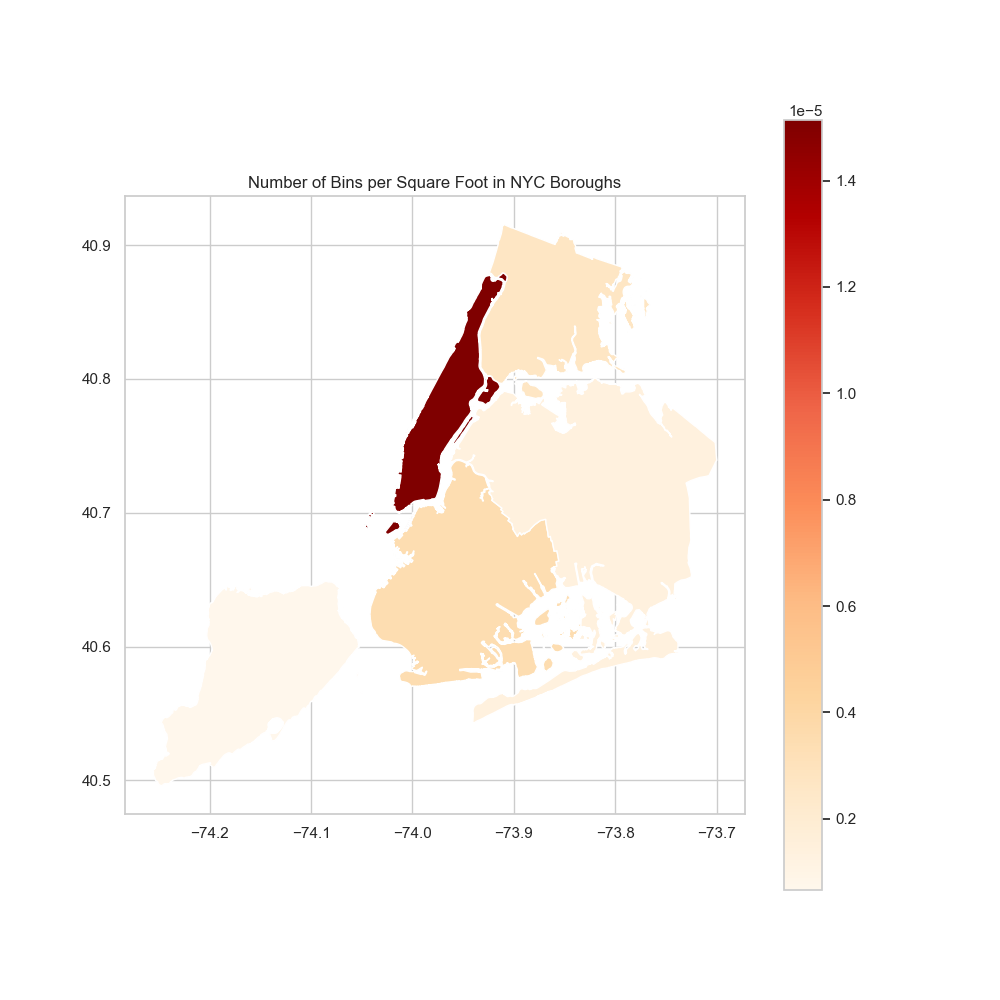

In [59]:
# Plot the boroughs and color each one based on the number of bins per square foot using the geometry column
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
bins_by_sqft.set_geometry('geometry').plot(column='bins_per_sqft', ax=ax, legend=True, cmap='OrRd')
ax.set_title('Number of Bins per Square Foot in NYC Boroughs')

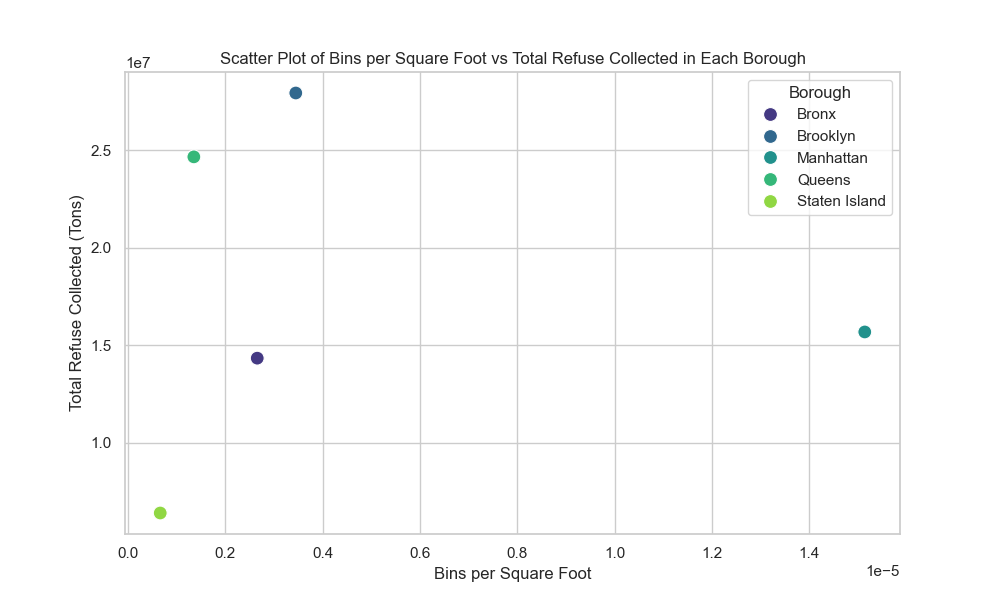

In [60]:
# Merge the bins per square foot data with the total refuse collected data
bins_and_refuse = bins_by_sqft.reset_index().merge(data, left_on='BoroName', right_on='BOROUGH')

# Plot the scatter plot of bins_per_sqft vs total refuse collected
plt.figure(figsize=(10, 6))
seaborn.scatterplot(data=bins_and_refuse, x='bins_per_sqft', y='REFUSETONSCOLLECTED', hue='BoroName', palette='viridis', s=100)
plt.title('Scatter Plot of Bins per Square Foot vs Total Refuse Collected in Each Borough')
plt.xlabel('Bins per Square Foot')
plt.ylabel('Total Refuse Collected (Tons)')
plt.legend(title='Borough')
plt.show()
